## Table of contents

* [1.Dealing with noisy data.](#1)
* [1.1 Outlier reducing the margin.](#1.1)
* [1.2.Outlier breaking linear separability.](#1.2)
* [2.Soft margin to the rescue.](#2.)
* [2.1 Understanding what C does](#2.1)
* [2.2. Summary ](#2.2)
* [3.Feature transformations ](#3)
* [3.1 How do we know which transformation to apply?](#3.1)
* [3.2 What is a kernel? ](#3.2)
* [3.3 The kernel trick ](#3.3)
* [4. Kernel types ](#4)
* [4.1. RBF or Gaussian kernel](#4.1)
* [4.2.Changing the value of gamma ](#4.2)
* [4.3. Other types](#4.3)
* [4.4.Which kernel should I use?](#4.4)
* [4.5.Summary ](#4.5)

## Grattiude:

This chapter is possible due to the References given below and thanks [Alexandre Kowalczyk](https://github.com/alexandrekow) for sharing such valuable knowledge for free.

**Note 1**: I had included the free [License](https://github.com/SyncfusionSuccinctlyE-Books/Support-Vector-Machines-Succinctly/blob/master/LICENSE)  in this folder.

**Note 2**: Except for the **Convex optimization code** and Data set,Rest of the Python code for visualization and plotting  is developed by [Anil R.Sarode](https://www.linkedin.com/in/anil-sarode-350556170/) 

## Prerequisites  <a class="anchor" id="P"></a>


Before start reading this chapter I strongly suggest that you already read the chapter [The Perceptron](https://github.com/AnilSarode/Machine-Learning-Digital-Book-/blob/master/The%20Perceptron/The%20Perceptron%20.ipynb). and the chapter [The SVM Optimization Problem](https://github.com/AnilSarode/Machine-Learning-Digital-Book-/blob/master/SVM-(Support%20Vector%20Machines%20)/The%20SVM%20Optimization%20Problem.ipynb).

## 1.Dealing with noisy data  <a class="anchor" id="1"></a>

The biggest issue with [hard margin SVM](https://github.com/AnilSarode/Machine-Learning-Digital-Book-/blob/master/SVM-(Support%20Vector%20Machines%20)/The%20SVM%20Optimization%20Problem.ipynb) is that it requires the data to be linearly separable. Real-life data is often noisy. Even when the data is linearly separable, a lot of things can happen before you feed it to your model. Maybe someone mistyped a value for an example, or maybe the probe of a sensor returned a crazy value. In the presence of an outlier (a data point that seems to be out of its group), there are two cases: the outlier can be closer to the other examples than most of the examples of its class, thus reducing the margin, or it can be among the other examples and break linear separability. Let us consider these two cases and see how the hard margin SVM deals with them.

### 1.1 Outlier reducing the margin <a class="anchor" id="1.1"></a>

When the data is linearly separable, the hard margin classifier does not behave as we would like in the presence of outliers.
Let us now consider our dataset with the addition of an outlier data point at (5, 7), as shown in

In [2]:
import numpy as np
from succinctly.datasets import get_dataset, linearly_separable as ls
X, y = get_dataset(ls.get_training_examples)
X=np.append(X,[[5,7]],axis=0)
y=np.append(y,[-1],axis=0)

In [3]:
import cvxopt.solvers

# See Appendix A for more information about the dataset
#from succinctly.datasets import get_dataset, linearly_separable as ls

#X, y = get_dataset(ls.get_training_examples)
m = X.shape[0]

# Gram matrix - The matrix of all possible inner products of X.
K = np.array([np.dot(X[i], X[j])for j in range(m) for i in range(m)]).reshape((m, m))

P = cvxopt.matrix(np.outer(y, y) * K)
q = cvxopt.matrix(-1 * np.ones(m))

# Equality constraints
A = cvxopt.matrix(y, (1, m))
b = cvxopt.matrix(0.0)

# Inequality constraints
G = cvxopt.matrix(np.diag(-1 * np.ones(m)))
h = cvxopt.matrix(np.zeros(m))

# Solve the problem
solution = cvxopt.solvers.qp(P, q, G, h, A, b)

# Lagrange multipliers
multipliers = np.ravel(solution['x'])

# Support vectors have positive multipliers.
has_positive_multiplier = multipliers > 1e-7
sv_multipliers = multipliers[has_positive_multiplier]

support_vectors = X[has_positive_multiplier]
support_vectors_y = y[has_positive_multiplier]

     pcost       dcost       gap    pres   dres
 0: -4.9666e+00 -9.9510e+00  5e+01  6e+00  2e+00
 1: -1.2173e+01 -1.1302e+01  2e+01  3e+00  9e-01
 2: -4.2247e+01 -3.3684e+01  2e+01  2e+00  7e-01
 3:  2.6134e+00 -8.5237e+00  2e+01  3e-01  1e-01
 4: -2.1415e+00 -1.1231e+01  2e+01  2e-01  7e-02
 5: -5.6409e+00 -6.5789e+00  1e+00  1e-03  4e-04
 6: -6.4361e+00 -6.4465e+00  1e-02  1e-05  4e-06
 7: -6.4444e+00 -6.4445e+00  1e-04  1e-07  4e-08
 8: -6.4444e+00 -6.4444e+00  1e-06  1e-09  4e-10
Optimal solution found.


In [4]:
def compute_w(multipliers, X, y):
    return np.sum(multipliers[i] * y[i] * X[i]for i in range(len(y)))

In [5]:
w = compute_w(multipliers, X, y)
w_from_sv = compute_w(sv_multipliers, support_vectors, support_vectors_y)
print(w) 
print(w_from_sv)

[1.33333337 3.33333338]
[1.33333328 3.33333346]


/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


In [6]:
def compute_b(w, X, y):
    return np.sum([y[i] - np.dot(w, X[i])for i in range(len(X))])/len(X)

In [7]:
b = compute_b(w, support_vectors, support_vectors_y) 
b

-31.000000546847417

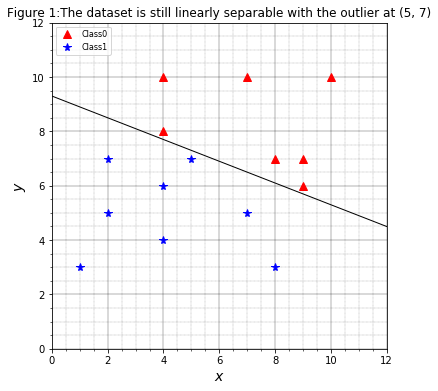

In [8]:

import matplotlib.pyplot as plt

#X, y = get_dataset(ls.get_training_examples)
x1= np.arange(0,13,1)

a0=X[0:7,0]
b0=X[0:7,1]
c0=X[7:16,0]
d0=X[7:16,1]

x_l= np.arange(0,12,1)
y_l= np.arange(0,12,1)


b1=b
a1= -w[0]/w[1]
c1=-b1/w[1]
y1=a1*x1+c1

fig = plt.figure(figsize=(6,6))

plt.plot(a0,b0,"r^",c0,d0,"b*",markersize=8)
plt.plot(x1,y1,'k',linewidth=1)

plt.title('Figure 1:The dataset is still linearly separable with the outlier at (5, 7)',fontsize=12)

plt.xlabel(r'$x$',fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
# Customize the minor grid

plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.legend(["Class0", "Class1"], loc="upper left",prop=dict(size=8))
plt.ylim(0,12)
plt.xlim(0,12)
plt.show()

In this case, we can see that the margin is very narrow, and it seems that the **outlier** is the main reason for this change. Intuitively, we can see that this hyperplane might not be the best at separating the data, and that it will probably generalize poorly.

### 1.2.Outlier breaking linear separability  <a class="anchor" id="1.2"></a>

Even worse, when the outlier breaks the linear separability, as the point (7, 8) does in Figure 2, the classifier is incapable of finding a hyperplane. We are stuck because of a single data point.

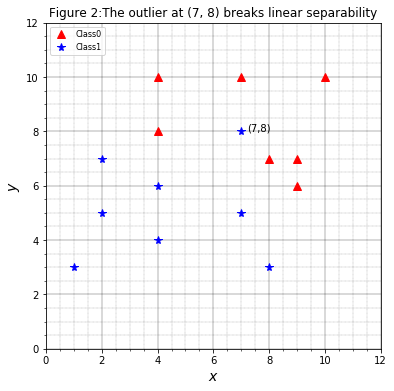

In [9]:
from succinctly.datasets import get_dataset, linearly_separable as ls
import matplotlib.pyplot as plt

X, y = get_dataset(ls.get_training_examples)
X=np.append(X,[[7,8]],axis=0)
y=np.append(y,[-1],axis=0)

x1= np.arange(0,13,1)

a0=X[0:7,0]
b0=X[0:7,1]
c0=X[7:15,0]
d0=X[7:15,1]

# b1=b
# a1= -w[0]/w[1]
# c1=-b1/w[1]
# y1=a1*x1+c1
x_l= np.arange(0,12,1)
y_l= np.arange(0,12,1)



fig = plt.figure(figsize=(6,6))

plt.plot(a0,b0,"r^",c0,d0,"b*",markersize=8)
#plt.plot(x1,y1,'k',linewidth=1)

plt.title('Figure 2:The outlier at (7, 8) breaks linear separability',fontsize=12)

plt.xlabel(r'$x$',fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
# Customize the minor grid

plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.annotate("(7,8)", xy=(7.2, 8))
plt.legend(["Class0", "Class1"], loc="upper left",prop=dict(size=8))
plt.ylim(0,12)
plt.xlim(0,12)
plt.show()

## 2.Soft margin to the rescue <a class="anchor" id="2."></a>

#### Slack variables

In 1995, Vapnik and Cortes introduced a modified version of the original SVM that allows the classifier to make some mistakes. The goal is now not to make **zero classification mistakes**, but to make as few mistakes as possible.

To do so, they modified the constraints of the optimization problem by adding a variable $\zeta$ (zeta). So the constraint

$$
y_{i}(\mathbf{w\cdot x_{i}}+b) \leq 1
$$

becomes:

$$
y_{i}(\mathbf{w\cdot x_{i}}+b) \leq 1-\zeta_{i}
$$

As a result, when minimizing the objective function, it is possible to satisfy the constraint even if
the example does not meet the original constraint (that is, it is too close from the hyperplane, or
it is not on the correct side of the hyperplane). This is illustrated in Code Listing.


In [10]:
import numpy as np

w = np.array([0.4, 1])
b = -10

x = np.array([6, 8])
y = -1

def constraint(w, b, x, y):
    return y * (np.dot(w, x) + b)

def hard_constraint_is_satisfied(w, b, x, y):
    return constraint(w, b, x, y) >= 1

def soft_constraint_is_satisfied(w, b, x, y, zeta):
    return constraint(w, b, x, y) >= 1 - zeta

# While the constraint is not satisfied for the example (6,8).
print(hard_constraint_is_satisfied(w, b, x, y))

# We can use zeta = 2 and satisfy the soft constraint.
print(soft_constraint_is_satisfied(w, b, x, y, zeta=2))

False
True


The problem is that we could choose a huge value of $\zeta$ for every example, and all the constraints will be satisfied

In [11]:
# We can pick a huge zeta for every point
# to always satisfy the soft constraint.
print(soft_constraint_is_satisfied(w, b, x, y, zeta=10)) # True
print(soft_constraint_is_satisfied(w, b, x, y, zeta=1000)) # True

True
True


To avoid this, we need to modify the objective function to penalize the choice of a big $\zeta_{i}$:

$$
\begin{equation}
\begin{aligned}
&\underset{\mathbf{w},b, \zeta}{\text{minimize}} \ \frac{1}{2} {\|\mathbf{w}\|}^{2} + \sum_{i=1}^{m}\zeta_{i}\\
&\textrm{subject to } y_{i}(\mathbf{w\cdot x_{i}}+b) \geq  1-zeta_{i}, i=1,\ldots,m \\
\end{aligned}
\end{equation}
$$


We take the sum of all individual $\zeta_{i}$ and add it to the objective function. Adding such a penalty is called **regularization.** As a result, the solution will be the hyperplane that maximizes the margin while having the smallest error possible.

There is still a little problem. With this formulation, one can easily minimize the function by using negative values of $\zeta_{i}$ . We add the constraint $\zeta \leq 0$ to prevent this. Moreover, we would like to
keep some control over the soft margin. Maybe sometimes we want to use the hard margin after all, that is why we add the parameter $C$, which will help us to determine how important the $\zeta$ should be (more on that later).

This leads us to the **soft margin formulation:**

$$
\begin{equation}
\begin{aligned}
&\underset{\mathbf{w},b, \zeta}{\text{minimize}} \ \frac{1}{2} {\|\mathbf{w}\|}^{2} + \sum_{i=1}^{m}\zeta_{i}\\
&\textrm{subject to } y_{i}(\mathbf{w\cdot x_{i}}+b) \geq  1-\zeta_{i}\\
&\zeta_{i}\leq 0 \ \text{for any}\ i=1,\ldots,m \\
\end{aligned}
\end{equation}
$$

As shown by (Vapnik V. N., 1998), using the same technique as for the separable case, we find that we need to maximize **the same Wolfe dual as before, under a slightly different constraint:**


$$
\begin{equation}
\begin{aligned}
&\underset{\alpha}{\text{maximize}} \ \sum_{i=1}^{m}\alpha_{i}-\frac{1}{2}\sum_{i=1}^{m}\sum_{j=1}^{m} \alpha_{i}\alpha_{j} y_{i} y_{j}\mathbf{x}_{i}\cdot\mathbf{x}_{j} \\
&\textrm{subject to } \ 0 \leq \alpha_{i} \leq C ,\ \textrm{for any} \ i=1,\ldots,m \\
&\sum_{i=1}^{m}\alpha_{i}y_{i}=0
\end{aligned}
\end{equation}
$$

Here the constraint $\alpha \geq 0$ has been changed to become $0\leq \alpha_{i}\leq C$ . This constraint is often called the box constraint because the vector is constrained to lie inside the box with side length in the positive [orthant](https://en.wikipedia.org/wiki/Orthant#:~:text=In%20geometry%2C%20an%20orthant%20or,an%20octant%20in%20three%20dimensions.&text=By%20dimension%3A,an%20orthant%20is%20a%20quadrant.).

The optimization problem is also called **1-norm soft margin** because we are minimizing the 1-norm of the slack vector $\zeta$

### 2.1 Understanding what C does <a class="anchor" id="2.1"></a>

The parameter $C$ gives you control of how the SVM will handle errors. Let us now examine how changing its value will give different hyperplanes.

     pcost       dcost       gap    pres   dres
 0:  4.6517e+06 -6.1210e+08  1e+09  4e-01  1e-10
 1:  1.5025e+07 -1.0054e+08  2e+08  4e-02  4e-09
 2:  6.1922e+06 -7.9155e+06  1e+07  5e-04  5e-11
 3:  9.2100e+05 -1.0275e+06  2e+06  4e-14  1e-11
 4:  1.3211e+05 -1.4686e+05  3e+05  1e-13  3e-12
 5:  1.8893e+04 -2.0994e+04  4e+04  2e-15  2e-12
 6:  2.6884e+03 -3.0237e+03  6e+03  8e-15  4e-13
 7:  3.7773e+02 -4.4055e+02  8e+02  5e-15  2e-13
 8:  5.1107e+01 -6.6052e+01  1e+02  2e-15  8e-14
 9:  5.9930e+00 -1.0689e+01  2e+01  7e-16  2e-14
10:  1.3261e-01 -2.1364e+00  2e+00  2e-16  1e-14
11: -5.7275e-01 -7.6836e-01  2e-01  2e-16  5e-15
12: -7.1275e-01 -7.2132e-01  9e-03  2e-16  6e-15
13: -7.1602e-01 -7.1610e-01  9e-05  2e-16  8e-15
14: -7.1605e-01 -7.1605e-01  9e-07  2e-16  4e-15
15: -7.1605e-01 -7.1605e-01  9e-09  2e-16  6e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1862e+00 -2.1584e+00  5e+01  7e+00  1e-14
 1: -4.3547e-01 -1.9823e+00  3e+00  3e-01  1e-1

/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


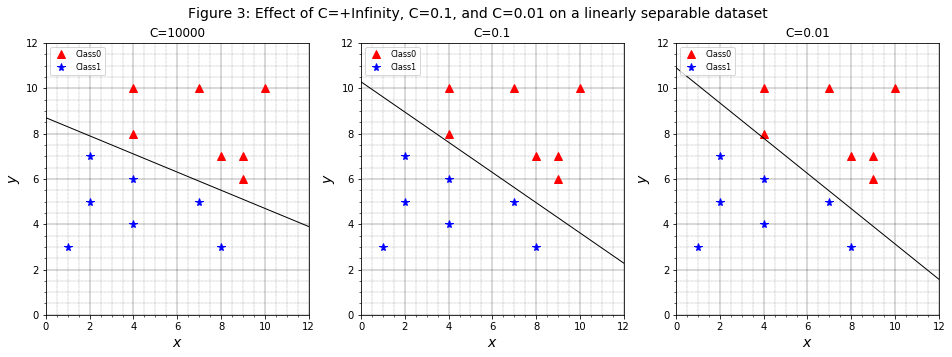

In [12]:
import numpy as np
import cvxopt.solvers
import math
import matplotlib.pyplot as plt

from succinctly.datasets import get_dataset, linearly_separable as ls
from cvxopt import matrix as cvxopt_matrix

X, y = get_dataset(ls.get_training_examples)
x1= np.arange(0,13,1)
fig = plt.figure(figsize=(16,5))
fig.suptitle("Figure 3: Effect of C=+Infinity, C=0.1, and C=0.01 on a linearly separable dataset", fontsize=14)
#plt.title('Figure 1:The dataset is still linearly separable with the outlier at (5, 7)',fontsize=12)

for k,C in enumerate([10000,0.1,0.01]):
    
    ax=plt.subplot(1, 3, k + 1)

    m = X.shape[0]

    # Gram matrix - The matrix of all possible inner products of X.
    K = np.array([np.dot(X[i], X[j])for j in range(m) for i in range(m)]).reshape((m, m))

    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-1 * np.ones(m))

    # Equality constraints
    A = cvxopt.matrix(y, (1, m))
    b = cvxopt.matrix(0.0)

    # Inequality constraints
    G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))

    # Solve the problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    multipliers = np.ravel(solution['x'])

    # Support vectors have positive multipliers.
    has_positive_multiplier = multipliers > 1e-7
    sv_multipliers = multipliers[has_positive_multiplier]

    support_vectors = X[has_positive_multiplier]
    support_vectors_y = y[has_positive_multiplier]
    
    w = compute_w(multipliers, X, y)
    
    w_from_sv = compute_w(sv_multipliers, support_vectors, support_vectors_y)
    
    b = compute_b(w, support_vectors, support_vectors_y) 



    a0=X[0:7,0]
    b0=X[0:7,1]
    c0=X[7:14,0]
    d0=X[7:14,1]

    x_l= np.arange(0,12,1)
    y_l= np.arange(0,12,1)


    b1=b
    a1= -w[0]/w[1]
    c1=-b1/w[1]
    y1=a1*x1+c1


    plt.plot(a0,b0,"r^",c0,d0,"b*",markersize=8)
    plt.plot(x1,y1,'k',linewidth=1)


    plt.xlabel(r'$x$',fontsize=14)
    plt.ylabel(r'$y$',fontsize=14)
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
    # Customize the minor grid

    plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    plt.legend(["Class0", "Class1"], loc=
               "upper left",prop=dict(size=8))
    ax.set_title("C={}".format(C))
    plt.ylim(0,12)
    plt.xlim(0,12)
plt.show()

The parameter $C$ gives you control of how the SVM will handle errors. Let us now examine how changing its value will give different hyperplanes.

Figure 3 above shows the linearly separable dataset we used throughout this book. On the left, we can see that setting $C$ to $+\infty$ gives us the same result as the hard margin classifier. However, if we choose a smaller value for $C$ like we did in the center, we can see that the hyperplane is closer to some points than others. The hard margin constraint is violated for these examples.Setting $C=0.01$ increases this behavior as depicted on the right.

What happens if we choose a $C$  very close to zero? Then there is basically no constraint anymore, and we end up with a hyperplane not classifying anything.

It seems that when the data is linearly separable, sticking with a big value for $C$ is the best choice (Which means $\alpha\geq 0 $ only and we come back to the hard margin it self).But what if we have some noisy outlier? In this case, as we can see in Figure 4, using $C=+\infty$ gives us a very narrow margin.However, **when we use $C=2$ , we end up with a hyperplane very close to the one of the hard margin classifier without outlier. The only violated constraint is the constraint of the outlier, and we are much more satisfied with this hyperplane.** This time, setting  $C=0.01$ ends up violating the constraint of another example, which was not an outlier. This value of seems $C$ to give too much freedom to our soft margin classifier

     pcost       dcost       gap    pres   dres
 0:  4.5048e+06 -7.4681e+08  2e+09  5e-01  1e-10
 1:  1.4821e+07 -1.3773e+08  2e+08  4e-02  4e-09
 2:  7.9614e+06 -1.8530e+07  3e+07  5e-03  4e-10
 3:  1.5204e+06 -1.9293e+06  3e+06  5e-13  4e-11
 4:  2.1926e+05 -2.4773e+05  5e+05  3e-13  1e-11
 5:  3.1369e+04 -3.5289e+04  7e+04  3e-14  5e-12
 6:  4.4484e+03 -5.0759e+03  1e+04  4e-14  3e-12
 7:  6.1729e+02 -7.4559e+02  1e+03  7e-15  6e-13
 8:  7.9316e+01 -1.1493e+02  2e+02  7e-15  3e-13
 9:  6.0438e+00 -2.0550e+01  3e+01  9e-16  9e-14
10: -4.0093e+00 -6.8477e+00  3e+00  2e-16  7e-14
11: -6.3988e+00 -6.5082e+00  1e-01  9e-16  5e-14
12: -6.4440e+00 -6.4451e+00  1e-03  2e-16  9e-14
13: -6.4444e+00 -6.4445e+00  1e-05  9e-16  1e-13
14: -6.4444e+00 -6.4444e+00  1e-07  9e-16  6e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.2489e+00 -7.4931e+01  2e+02  1e+00  3e-14
 1: -4.3399e+00 -3.3176e+01  5e+01  2e-01  4e-14
 2: -2.5089e+00 -7.7050e+00  7e+00  2e-02  2e-1

/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


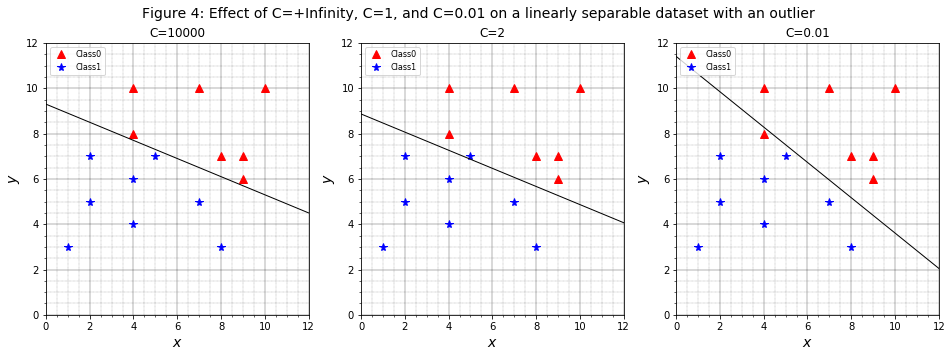

In [13]:
import numpy as np
import cvxopt.solvers
import math
import matplotlib.pyplot as plt

from succinctly.datasets import get_dataset, linearly_separable as ls
from cvxopt import matrix as cvxopt_matrix

X, y = get_dataset(ls.get_training_examples)
X=np.append(X,[[5,7]],axis=0)
y=np.append(y,[-1],axis=0)
x1= np.arange(0,13,1)
fig = plt.figure(figsize=(16,5))
fig.suptitle("Figure 4: Effect of C=+Infinity, C=1, and C=0.01 on a linearly separable dataset with an outlier", fontsize=14)
#plt.title('Figure 1:The dataset is still linearly separable with the outlier at (5, 7)',fontsize=12)

for k,C in enumerate([10000,2,0.01]):
    
    ax=plt.subplot(1, 3, k + 1)

    m = X.shape[0]

    # Gram matrix - The matrix of all possible inner products of X.
    K = np.array([np.dot(X[i], X[j])for j in range(m) for i in range(m)]).reshape((m, m))

    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-1 * np.ones(m))

    # Equality constraints
    A = cvxopt.matrix(y, (1, m))
    b = cvxopt.matrix(0.0)

    # Inequality constraints
    G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))

    # Solve the problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    multipliers = np.ravel(solution['x'])

    # Support vectors have positive multipliers.
    has_positive_multiplier = multipliers > 1e-7
    sv_multipliers = multipliers[has_positive_multiplier]

    support_vectors = X[has_positive_multiplier]
    support_vectors_y = y[has_positive_multiplier]
    
    w = compute_w(multipliers, X, y)
    
    w_from_sv = compute_w(sv_multipliers, support_vectors, support_vectors_y)
    
    b = compute_b(w, support_vectors, support_vectors_y) 



    a0=X[0:7,0]
    b0=X[0:7,1]
    c0=X[7:15,0]
    d0=X[7:15,1]

    x_l= np.arange(0,12,1)
    y_l= np.arange(0,12,1)


    b1=b
    a1= -w[0]/w[1]
    c1=-b1/w[1]
    y1=a1*x1+c1


    plt.plot(a0,b0,"r^",c0,d0,"b*",markersize=8)
    plt.plot(x1,y1,'k',linewidth=1)


    plt.xlabel(r'$x$',fontsize=14)
    plt.ylabel(r'$y$',fontsize=14)
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
    # Customize the minor grid

    plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    plt.legend(["Class0", "Class1"], loc="upper left",prop=dict(size=8))
    ax.set_title("C={}".format(C))
    plt.ylim(0,12)
    plt.xlim(0,12)
plt.show()

Eventually, in the case where the outlier makes the data non-separable,as shown in Figure 5  we cannot use $C=+\infty$  because there is no solution meeting all the hard margin constraints. Instead, we test several values of $C$, and we see that the best hyperplane is achieved with $C=3$ . In fact, we get the same hyperplane for all values of  $C$ greater than or equal to 3. That is because no matter how hard we penalize it, it is necessary to violate the constraint of the outlier to be able to separate the data. When we use a small $C$ , as before, more constraints are violated.

     pcost       dcost       gap    pres   dres
 0: -1.2113e+01 -1.3279e+02  3e+02  1e+00  4e-14
 1: -8.8593e+00 -5.0460e+01  5e+01  8e-02  7e-14
 2: -8.8625e+00 -1.3963e+01  5e+00  6e-03  4e-14
 3: -1.0209e+01 -1.1402e+01  1e+00  1e-03  5e-14
 4: -1.0639e+01 -1.0830e+01  2e-01  2e-04  6e-14
 5: -1.0715e+01 -1.0721e+01  6e-03  4e-06  6e-14
 6: -1.0716e+01 -1.0716e+01  6e-05  4e-08  8e-14
 7: -1.0716e+01 -1.0716e+01  6e-07  4e-10  6e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.2126e+00 -2.9684e+01  1e+02  2e+00  2e-14
 1: -4.1339e+00 -1.7678e+01  2e+01  3e-01  2e-14
 2: -3.2630e+00 -5.3018e+00  2e+00  2e-02  1e-14
 3: -3.7687e+00 -4.1748e+00  4e-01  3e-03  2e-14
 4: -3.8407e+00 -3.9673e+00  1e-01  4e-04  2e-14
 5: -3.9009e+00 -3.9055e+00  5e-03  1e-05  2e-14
 6: -3.9028e+00 -3.9028e+00  5e-05  2e-07  3e-14
 7: -3.9028e+00 -3.9028e+00  5e-07  2e-09  2e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -3.1763e+00 -3.2943e

/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/home/anil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


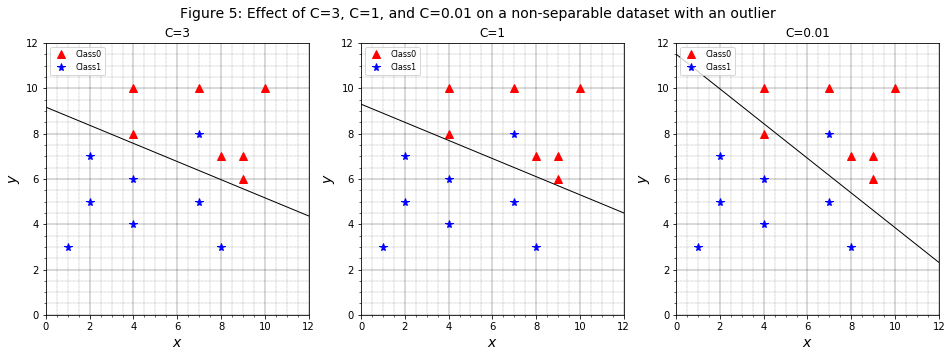

In [14]:
import numpy as np
import cvxopt.solvers
import math
import matplotlib.pyplot as plt

from succinctly.datasets import get_dataset, linearly_separable as ls
from cvxopt import matrix as cvxopt_matrix

X, y = get_dataset(ls.get_training_examples)
X=np.append(X,[[7,8]],axis=0)
y=np.append(y,[-1],axis=0)
x1= np.arange(0,13,1)
fig = plt.figure(figsize=(16,5))
fig.suptitle("Figure 5: Effect of C=3, C=1, and C=0.01 on a non-separable dataset with an outlier", fontsize=14)
#plt.title('Figure 1:The dataset is still linearly separable with the outlier at (5, 7)',fontsize=12)

for k,C in enumerate([3,1,0.01]):
    
    ax=plt.subplot(1, 3, k + 1)

    m = X.shape[0]

    # Gram matrix - The matrix of all possible inner products of X.
    K = np.array([np.dot(X[i], X[j])for j in range(m) for i in range(m)]).reshape((m, m))

    P = cvxopt.matrix(np.outer(y, y) * K)
    q = cvxopt.matrix(-1 * np.ones(m))

    # Equality constraints
    A = cvxopt.matrix(y, (1, m))
    b = cvxopt.matrix(0.0)

    # Inequality constraints
    G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
    h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))

    # Solve the problem
    solution = cvxopt.solvers.qp(P, q, G, h, A, b)

    # Lagrange multipliers
    multipliers = np.ravel(solution['x'])

    # Support vectors have positive multipliers.
    has_positive_multiplier = multipliers > 1e-7
    sv_multipliers = multipliers[has_positive_multiplier]

    support_vectors = X[has_positive_multiplier]
    support_vectors_y = y[has_positive_multiplier]
    
    w = compute_w(multipliers, X, y)
    
    w_from_sv = compute_w(sv_multipliers, support_vectors, support_vectors_y)
    
    b = compute_b(w, support_vectors, support_vectors_y) 



    a0=X[0:7,0]
    b0=X[0:7,1]
    c0=X[7:15,0]
    d0=X[7:15,1]

#     x_l= np.arange(0,12,1)
#     y_l= np.arange(0,12,1)


    b1=b
    a1= -w[0]/w[1]
    c1=-b1/w[1]
    y1=a1*x1+c1


    plt.plot(a0,b0,"r^",c0,d0,"b*",markersize=8)
    plt.plot(x1,y1,'k',linewidth=1)


    plt.xlabel(r'$x$',fontsize=14)
    plt.ylabel(r'$y$',fontsize=14)
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
    # Customize the minor grid

    plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    plt.legend(["Class0", "Class1"], loc="upper left",prop=dict(size=8))
    ax.set_title("C={}".format(C))
    plt.ylim(0,12)
    plt.xlim(0,12)
plt.show()

Rules of thumb:
* A small$C$ will give a wider margin, at the cost of some misclassifications.
* A huge $C$ will give the hard margin classifier and tolerates zero constraint violation.
* The key is to find the value of $C$ such that noisy data does not impact the solution too much.

There is no magic value $C$ for that will work for all the problems. The recommended approach to select $C$ is to use [grid search](https://scikit-learn.org/stable/modules/grid_search.html) with [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) (Hsu, Chang, & Lin, A Practical Guide to Support Vector Classification). The crucial thing to understand is that the value of $C$ is very specific to the data you are using, so if one day you found that $C=0.001$ did not work for one of your problems, you should still try this value with another problem, because it will not have the same effect

## 2.2. Summary <a class="anchor" id="2.2"></a>

The soft-margin SVM formulation is a nice improvement over the hard-margin classifier. It allows us to classify data correctly even when there is noisy data that breaks linear separability. However, the cost of this added flexibility is that we now have an **hyperparameter $C$** , for which we need to find a value. We saw how changing the value of $C$ impacts the margin and allows the classifier to make some mistakes in order to have a bigger margin.  **This once again reminds us that our goal is to find a hypothesis that will work well on unseen data. A few mistakes on the training data is not a bad thing if the model generalizes well in the end.**

## 3.Feature transformations <a class="anchor" id="3"></a>

### Can we classify non-linearly separable data?

Imagine you have some data that is not separable (like the one in Figure 6), and you would like to use SVMs to classify it. We have seen that it is not possible because the data is not linearly separable. However, this last assumption is not correct. What is important to notice here is that the data is not linearly separable in **two dimensions.**

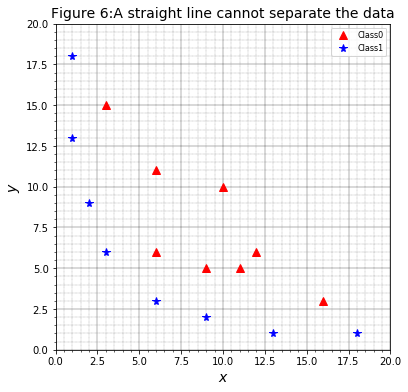

In [15]:
import numpy as np
from succinctly.datasets import get_dataset, non_separable_poly as nsp
import matplotlib.pyplot as plt


X_data, y_data = get_dataset(nsp.get_training_examples)

a=X_data[0:8,0]
b=X_data[0:8,1]
c=X_data[8:16,0]
d=X_data[8:16,1]

# x_l= np.arange(0,20,1)
# y_l= np.arange(0,20,1)

fig = plt.figure(figsize=(6,6))

plt.plot(a,b,"r^",c,d,"b*",markersize=8)
plt.title('Figure 6:A straight line cannot separate the data',fontsize=14)

plt.xlabel(r'$x$',fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
# Customize the minor grid

plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.legend(["Class0", "Class1"], loc="upper right",prop=dict(size=8))
plt.ylim(0,20)
plt.xlim(0,20)
plt.show()


Even if your original data is in two dimensions, nothing prevents you from transforming it before feeding it into the SVM. One possible transformation would be, for instance, to transform every two-dimensional vector $(x_1,x_2)$ into a three-dimensional vector.

For example, we can do what is called a polynomial mapping by applying the function $\phi :\Bbb{R}^2\rightarrow \Bbb{R}^3$ defined by:

$$
\phi(x_{1},x_{2})=(x_{1}^2,\sqrt{2}x_{1}x_{2},x_{2}^2)
$$

Code Listing below shows this transformation implemented in Python

In [16]:
# Transform a two-dimensional vector x into a three-dimensional vector.
def transform(x):
    return [x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2]

If you transform the whole data set of Figure 6 and plot the result, you get Figure 7, which does not show much improvement. However, after some time playing with the graph, we can see that the data is, in fact, separable in three dimensions (Figure 8 and Figure 9)!

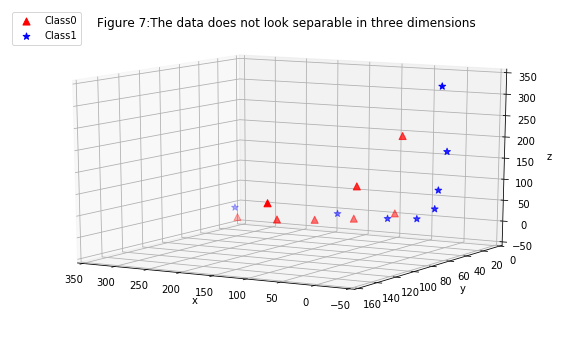

In [17]:

import numpy as np

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X_data, y_data = get_dataset(nsp.get_training_examples)

# Transform a two-dimensional vector x into a three-dimensional vector.
def transform(x):
    return [x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2]


fig = plt.figure(figsize=(10,6))
r=np.zeros((16,3))
for i,j in enumerate( X_data):
    r[i]=transform(j)

ax = plt.subplot(projection='3d')
ax.scatter3D(r[0:8, 0], r[0:8, 1], r[0:8,2], c='r',marker='^', s=50)
ax.scatter3D(r[8:16, 0], r[8:16, 1], r[8:16,2], c='b',marker='*', s=50)
plt.title('Figure 7:The data does not look separable in three dimensions')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-50,350])
ax.set_ylim([0,160])
ax.set_zlim([-50,350])

ax.view_init(12.5, 120)

# # Turn on the minor TICKS, which are required for the minor GRID
# plt.minorticks_on()

# # Customize the major grid
# plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
# # Customize the minor grid

# plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.legend(["Class0", "Class1"], loc="upper left")
plt.show()
# ax.view_init(12.5, 180)
# #ax.view_init(12.5, 360)
# ax.set_zlim([-2000000,2000000])

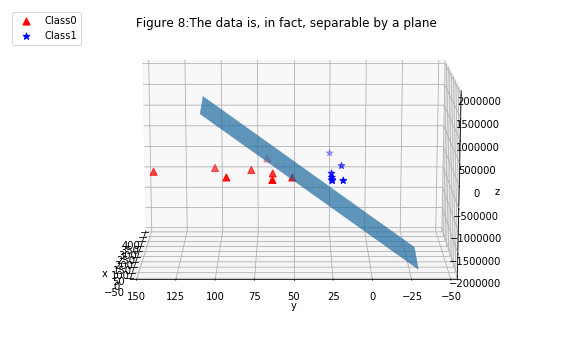

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X_data, y_data = get_dataset(nsp.get_training_examples)

# Transform a two-dimensional vector x into a three-dimensional vector.
def transform(x):
    return [x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2]


fig = plt.figure(figsize=(10,6))
r=np.zeros((16,3))
for i,j in enumerate( X_data):
    r[i]=transform(j)
    
ax = plt.subplot(projection='3d')
ax.scatter3D(r[0:8, 0], r[0:8, 1], r[0:8,2], c='r',marker='^', s=50)
ax.scatter3D(r[8:16, 0], r[8:16, 1], r[8:16,2], c='b',marker='*', s=50)
plt.title('Figure 8:The data is, in fact, separable by a plane')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(12.5, 180)
ax.set_xlim([-50,400])
ax.set_zlim([-2000000,2000000])
ax.set_ylim([-50,150])

point  = np.array([300, 35, 1])
normal = np.array([1,25, -0.001])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(-25,125), range(-30,110))    

# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
ax.plot_surface(xx, yy, z)
plt.legend(["Class0", "Class1"], loc="upper left")
plt.show()



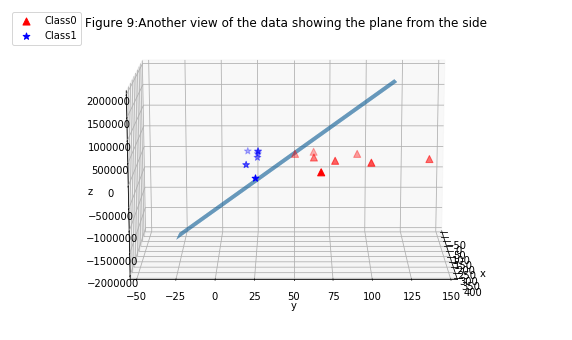

In [19]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X_data, y_data = get_dataset(nsp.get_training_examples)

# Transform a two-dimensional vector x into a three-dimensional vector.
def transform(x):
    return [x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2]


fig = plt.figure(figsize=(10,6))
r=np.zeros((16,3))
for i,j in enumerate( X_data):
    r[i]=transform(j)
    
ax = plt.subplot(projection='3d')
ax.scatter3D(r[0:8, 0], r[0:8, 1], r[0:8,2], c='r',marker='^', s=50)
ax.scatter3D(r[8:16, 0], r[8:16, 1], r[8:16,2], c='b',marker='*', s=50)
plt.title('Figure 9:Another view of the data showing the plane from the side')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(12.5, 360)
ax.set_xlim([-50,400])
ax.set_zlim([-2000000,2000000])
ax.set_ylim([-50,150])

point  = np.array([400, 35, 0])
normal = np.array([1,25, -0.001])

# a plane is a*x+b*y+c*z+d=0
# [a,b,c] is the normal. Thus, we have to calculate
# d and we're set
d = -point.dot(normal)

# create x,y
xx, yy = np.meshgrid(range(-25,100), range(-30,120))    

# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]
ax.plot_surface(xx, yy, z)
plt.legend(["Class0", "Class1"], loc="upper left")
plt.show()



Here is a basic recipe we can use to classify this dataset:
    
1. Transform every two-dimensional vector into a three-dimensional vector using the
transform method of the function `transform(x)`.

2. Train the SVMs using the 3D dataset.

3. For each new example we wish to predict, transform it using the transform method before passing it to the **predict** method.

Of course, you are not forced to transform the data into three dimensions; it could be five, ten,
or one hundred dimensions

### 3.1 How do we know which transformation to apply? <a class="anchor" id="3.1"></a>

Choosing which transformation to apply depends a **lot on your dataset.** Being able to transform the data so that the machine learning algorithm you wish to use performs at its best is probably one key factor of success in the machine learning world. Unfortunately, there is no perfect recipe, and it will come with experience via trial and error. Before using any algorithm, be sure to check if there are some common rules to transform the data detailed in the documentation. For more information about how to prepare your data, you can read [the dataset transformation section on the scikit-learn websit](https://scikit-learn.org/stable/data_transforms.html)

### 3.2 What is a kernel? <a class="anchor" id="3.2"></a>

In the last section, we saw a quick recipe to use on the non-separable dataset. One of its main drawbacks is that we must transform every example. If we have millions or billions of examples and that transform method is complex, that can take a huge amount of time. This is when kernels come to the rescue.

If you recall, when we search for the KKT multipliers in the Wolfe dual Lagrangian function, we do not need the value of a training example $\mathbf{x}$ ; we only need the value of the dot product $\mathbf{x_{i}}.\mathbf{x_{j}}$ between two training examples.

$$
\begin{equation}
\begin{aligned}
W(\alpha)=\sum_{i=1}^{m}\alpha_{i}-\frac{1}{2}\sum_{i=1}^{m}\sum_{j=1}^{m} \alpha_{i}\alpha_{j} y_{i} y_{j}\mathbf{x}_{i}\cdot\mathbf{x}_{j}
\end{aligned}
\end{equation}
$$



In Code Listing below, we apply the first step of our recipe. Imagine that when the data is used to learn, the only thing we care about is the value returned by the dot product, in this example 8,100.

In [20]:
x1 = [3,6]
x2 = [10,10]

x1_3d = transform(x1)
x2_3d = transform(x2)

In [21]:
print(np.dot(x1_3d,x2_3d))

8100.0


The question is this: **Is there a way to compute this value, without transforming the vectors?**
And the answer is: Yes, with a kernel!

Let us consider the function in Code Listing below:

In [22]:
def polynomial_kernel(a, b):
    return a[0]**2 * b[0]**2 + 2*a[0]*b[0]*a[1]*b[1] + a[1]**2 * b[1]**2

Using this function with the same two examples as before returns the same result.

In [23]:
x1 = [3,6]
x2 = [10,10]
# We do not transform the data.
print(polynomial_kernel(x1, x2))

8100


When you think about it, this is pretty incredible.

The vectors $\mathbf{x_{1}}$ and $\mathbf{x_{2}}$ belong to $\Bbb{R}^2$. The kernel function computes their dot product as if they have been transformed into vectors belonging to $\Bbb{R}^3$ , and it does that without doing the transformation, and without computing their dot product!

To sum up: a kernel is a function that returns the result of a dot product performed in another
space. More formally, we can write

**Definition:**  Given a mapping function $\phi: \mathcal{X} \rightarrow  \mathcal{V} $, we call the function $K: \mathcal{X} \rightarrow \Bbb{R}$ defined by $K(\mathbf{x},\mathbf{x}')= \langle \phi(\mathbf{x},\phi(\mathbf{x'}))$, where $\langle \cdot,\cdot \rangle \mathcal{V} $ denotes an inner product in , a **kernel function**.

### 3.3 The kernel trick <a class="anchor" id="3.3"></a>

Now that we know what a kernel is, we will see what the **kernel trick** is.

If we define a kernel as:$K(\mathbf{x_{i}},\mathbf{x_{j}})= \mathbf{x_{i}}.\mathbf{x_{j}}$ , we can then rewrite the soft-margin dual problem:

$$
\begin{equation}
\begin{aligned}
&\underset{\alpha}{\text{maximize}} \ \sum_{i=1}^{m}\alpha_{i}-\frac{1}{2}\sum_{i=1}^{m}\sum_{j=1}^{m} \alpha_{i}\alpha_{j} y_{i} y_{j}K(\mathbf{x}_{i},\mathbf{x}_{j}) \\
&\textrm{subject to } \ 0 \leq \alpha_{i} \leq C ,\ \textrm{for any} \ i=1,\ldots,m \\
&\sum_{i=1}^{m}\alpha_{i}y_{i}=0
\end{aligned}
\end{equation}
$$

That’s it. We have made a single change to the dual problem—we call it the kernel trick.


This change looks very simple, but remember that it took a serious amount of work to derive the
Wolf dual formulation from the original optimization problem. We now have the power to change
the kernel function in order to classify non-separable data.


$$
h(\mathbf x_{i})=\textrm{sign}\bigg(\sum_{j=1}^{S} \alpha_{j} y_{j}K(\mathbf{x}_{j},\mathbf{x}_{i})+b\bigg)
$$

Of course, we also need to change the hypothesis function to use the kernel function: Remember that in this formula is the set of support vectors. Looking at this formula, we better understand why SVMs are also called **sparse kernel machines.** It is because they only need to compute the kernel function on the support vectors and not on all the vectors, like other kernel methods (Bishop, 2006)


## 4. Kernel types <a class="anchor" id="4"></a>

### Linear kernel


This is the simplest kernel. It is simply defined by:
$$
K(\mathbf{x},\mathbf{x}')= \mathbf{x}\cdot\mathbf{x}'
$$

where $\mathbf{x}$ and $\mathbf{x}'$ are two vectors.
In practice, you should know that a linear kernel works well for [text classification.](https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/)

###  Polynomial kernel

We already saw the polynomial kernel earlier when we introduced kernels, but this time we will
consider the more generic version of the kernel:

$$
K(\mathbf{x},\mathbf{x}')= (\mathbf{x}\cdot\mathbf{x}'+c)^{d}
$$

It has two parameters:$c$,which represents a constant term, and $d$ , which represents the degree
of the kernel. This kernel can be implemented easily in Python, as shown in Code Listing below.

**Note:** If you want to know more explore more intuition behind the kernel here is the excellent [blog](https://xavierbourretsicotte.github.io/Kernel_feature_map.html) and also [here](https://stats.stackexchange.com/questions/152897/how-to-intuitively-explain-what-a-kernel-is) very good answers.  

In [24]:
def polynomial_kernel(a, b, degree, constant=0):
    result = sum([a[i] * b[i] for i in range(len(a))]) + constant
    return pow(result, degree)

In Code Listing below, we see that it returns the same result as the kernel of Code Listing above when
we use the degree 2

In [25]:
x1 = [3,6]
x2 = [10,10]
# We do not transform the data.
print(polynomial_kernel(x1, x2, degree=2)) # 8100

8100


Here to show the implementation of the SVM using Polynomial kernel for above plotted (Figure 6) `non_separable_poly` data set I will use `from sklearn import svm` instead of `cvxopt.solvers`.The official document for support vector machine for [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and [user guide](https://scikit-learn.org/stable/modules/svm.html#svm-classification), for example of [Non-linear SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_nonlinear.html#sphx-glr-download-auto-examples-svm-plot-svm-nonlinear-py). 

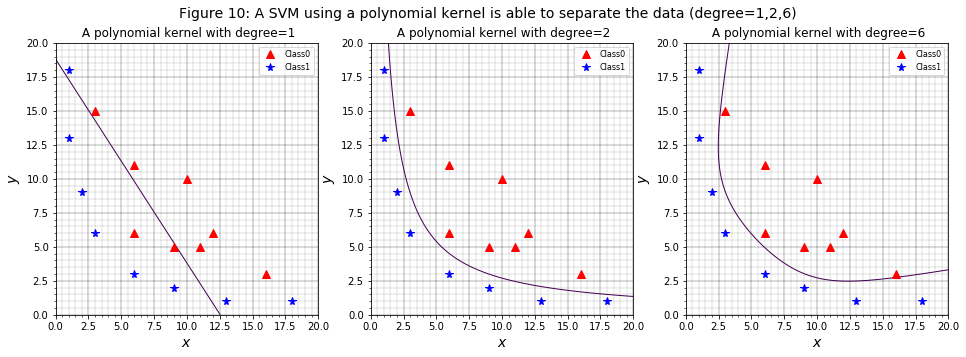

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from succinctly.datasets import get_dataset, non_separable_poly as nsp


xx, yy = np.meshgrid(np.linspace(0, 20, 500),
                     np.linspace(0, 20, 500))

X_data, y_data = get_dataset(nsp.get_training_examples)

fig = plt.figure(figsize=(16,5))
fig.suptitle("Figure 10: A SVM using a polynomial kernel is able to separate the data (degree=1,2,6)", fontsize=14)

for k,degree in enumerate([1,2,6]):
    d=degree
    ax=plt.subplot(1, 3, k + 1)
    if d==1:
        C=0.5
    elif d>1:
        C=0.1
    # fit the model
    clf = svm.NuSVC(nu=C,kernel='poly',degree=d ,gamma='auto')
    clf.fit(X_data, y_data)

    a0=X_data[0:8,0]
    b0=X_data[0:8,1]
    c0=X_data[8:16,0]
    d0=X_data[8:16,1]

    plt.plot(a0,b0,"r^",c0,d0,"b*",markersize=8)

    # plot the decision function for each datapoint on the grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=1,linestyles='-')
    
    plt.xlabel(r'$x$',fontsize=14)
    plt.ylabel(r'$y$',fontsize=14)
    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
    # Customize the minor grid

    plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    plt.legend(["Class0", "Class1"], loc="upper right",prop=dict(size=8))
    ax.set_title(" A polynomial kernel with degree={}".format(degree))
plt.show()

### Updating the degree

A polynomial kernel with a degree of 1 and no constant is simply the linear kernel as shown above Figure 10 in extreme left plot,When you increase the degree of a polynomial kernel, the decision boundary will become more complex and will have a tendency to be influenced by individual data examples, as illustrated above in Figure 10 extreme right. Using a high-degree polynomial is dangerous because you can often achieve better performance on your test set, but it leads to what is called **overfitting**: the model is too close to the data and does not generalize well.

**Note:** Using a high-degree polynomial kernel will often lead to overfitting.


### 4.1. RBF or Gaussian kernel <a class="anchor" id="4.1"></a>


Sometimes polynomial kernels are not sophisticated enough to work. When you have a difficult dataset like the one depicted in Figure 11, this type of kernel will show its limitation.

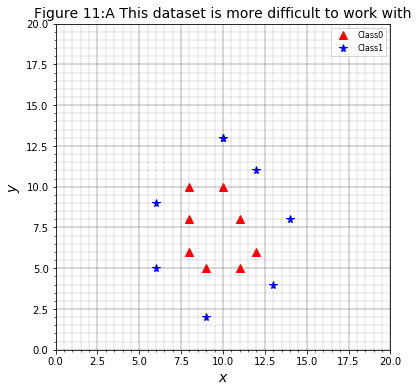

In [32]:
import numpy as np
from succinctly.datasets import get_dataset, non_separable_rbf as nrbf
import matplotlib.pyplot as plt
from sklearn import svm

X_data1, y_data2 = get_dataset(nrbf.get_training_examples)

a=X_data1[0:8,0]
b=X_data1[0:8,1]
c=X_data1[8:16,0]
d=X_data1[8:16,1]

# x_l= np.arange(0,20,1)
# y_l= np.arange(0,20,1)

fig = plt.figure(figsize=(6,6))

plt.plot(a,b,"r^",c,d,"b*",markersize=8)
plt.title('Figure 11:A This dataset is more difficult to work with',fontsize=14)

plt.xlabel(r'$x$',fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
# Customize the minor grid

plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.legend(["Class0", "Class1"], loc="upper right",prop=dict(size=8))
plt.ylim(0,20)
plt.xlim(0,20)
plt.show()



As we can see in Figure 12, the decision boundary is very bad at classifying the data.

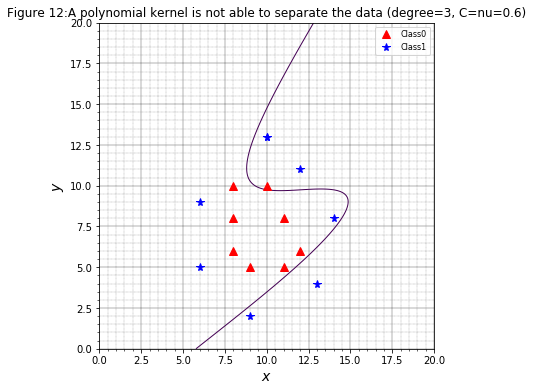

In [62]:
import numpy as np
from succinctly.datasets import get_dataset, non_separable_rbf as nrbf
import matplotlib.pyplot as plt

X_data1, y_data2 = get_dataset(nrbf.get_training_examples)
    
# fit the model
clf = svm.NuSVC(nu=0.6,kernel='poly',degree=3 ,gamma='auto')
clf.fit(X_data1, y_data2)

a0=X_data1[0:8,0]
b0=X_data1[0:8,1]
c0=X_data1[8:16,0]
d0=X_data1[8:16,1]

fig = plt.figure(figsize=(6,6))
plt.title('Figure 12:A polynomial kernel is not able to separate the data (degree=3, C=nu=0.6)',fontsize=12)

plt.plot(a0,b0,"r^",c0,d0,"b*",markersize=8)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

contours = plt.contour(xx, yy, Z, levels=[0], linewidths=1,linestyles='-')
    
plt.xlabel(r'$x$',fontsize=14)
plt.ylabel(r'$y$',fontsize=14)
# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.legend(["Class0", "Class1"], loc="upper right",prop=dict(size=8))
plt.show()

This case calls for us to use another, more complicated, kernel: the **Gaussian kernel.** It is also named RBF kernel, where RBF stands for Radial Basis Function. A radial basis function is a function whose value depends only on the distance from the origin or from some point.

The RBF kernel function is

$$
K(\mathbf{x,x'}) = \exp \left( - \frac{ || \mathbf{x - x'} ||^2}{2\sigma^2} \right)
$$

$$
K(\mathbf{x,x'}) = \exp \left( - \gamma || \mathbf{x - x'} ||^2 \right)
$$

You will often read that it projects vectors into an infinite dimensional space. What does this mean?

Recall this definition: a kernel is a **function** that returns the result of a dot product performed in
another space.

In the case of the polynomial kernel example we saw earlier, the kernel returned the result of a dot product performed in $\Bbb{R}^{3}$. As it turns out, the RBF kernel returns the result of a dot product performed in $\Bbb{R}^{\infty}$. I will not go into details here, but if you wish, you can read [this proof](http://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/svms/RBFKernel.pdf) to better understand how we came to this conclusion.

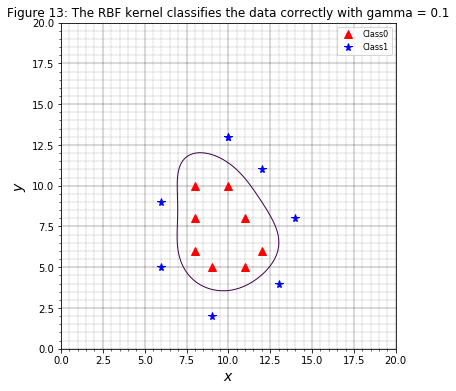

In [63]:
import numpy as np
from succinctly.datasets import get_dataset, non_separable_rbf as nrbf
import matplotlib.pyplot as plt

X_data1, y_data2 = get_dataset(nrbf.get_training_examples)
    
# fit the model
clf = svm.NuSVC(nu=0.5,kernel='rbf',degree=2 ,gamma=1.e-1)
clf.fit(X_data1, y_data2)

a0=X_data1[0:8,0]
b0=X_data1[0:8,1]
c0=X_data1[8:16,0]
d0=X_data1[8:16,1]

fig = plt.figure(figsize=(6,6))
plt.title('Figure 13: The RBF kernel classifies the data correctly with gamma = 0.1',fontsize=12)

plt.plot(a0,b0,"r^",c0,d0,"b*",markersize=8)

# plot the decision function for each datapoint on the grid
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

contours = plt.contour(xx, yy, Z, levels=[0], linewidths=1,linestyles='-')
    
plt.xlabel(r'$x$',fontsize=14)
plt.ylabel(r'$y$',fontsize=14)

# Turn on the minor TICKS, which are required for the minor GRID
plt.minorticks_on()

# Customize the major grid
plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
# Customize the minor grid
plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.legend(["Class0", "Class1"], loc="upper right",prop=dict(size=8))
plt.show()

[This video](https://www.youtube.com/watch?v=3liCbRZPrZA) is particularly useful to understand how the RBF kernel is able to separate the data.


### 4.2.Changing the value of gamma <a class="anchor" id="4.2"></a>


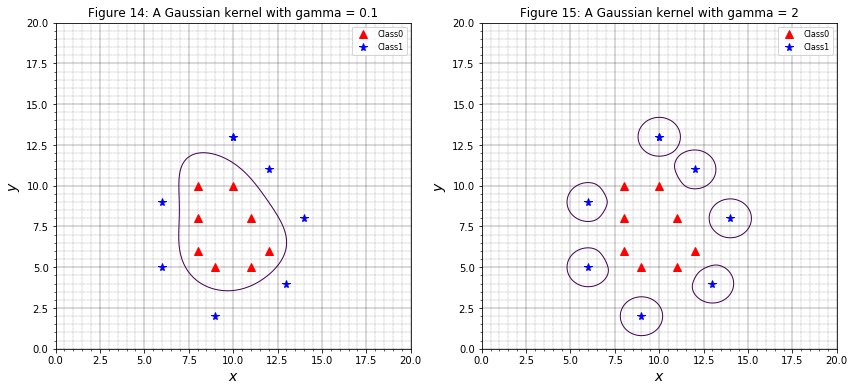

In [64]:
import numpy as np
from succinctly.datasets import get_dataset, non_separable_rbf as nrbf
import matplotlib.pyplot as plt

X_data1, y_data2 = get_dataset(nrbf.get_training_examples)

fig = plt.figure(figsize=(14,6))

for k,g in enumerate([1.e-1,2]):
    
    ax=plt.subplot(1, 2, k + 1)
    # fit the model
    clf = svm.NuSVC(nu=0.5,kernel='rbf',degree=2 ,gamma=g)
    clf.fit(X_data1, y_data2)

    a0=X_data1[0:8,0]
    b0=X_data1[0:8,1]
    c0=X_data1[8:16,0]
    d0=X_data1[8:16,1]


    plt.plot(a0,b0,"r^",c0,d0,"b*",markersize=8)

    # plot the decision function for each datapoint on the grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    contours = plt.contour(xx, yy, Z, levels=[0], linewidths=1,linestyles='-')

    plt.xlabel(r'$x$',fontsize=14)
    plt.ylabel(r'$y$',fontsize=14)

    # Turn on the minor TICKS, which are required for the minor GRID
    plt.minorticks_on()

    # Customize the major grid
    plt.grid(which='major', linestyle='-', linewidth='0.3', color='black')
    # Customize the minor grid
    plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    plt.legend(["Class0", "Class1"], loc="upper right",prop=dict(size=8))
    ax.set_title("Figure {}: A Gaussian kernel with gamma = {}".format(k+14,g))
plt.show()

When gamma is too small, as in Figure 14, the model behaves like a linear SVM. When gamma is too large, the model is too heavily influenced by each support vector, as shown in Figure 15. For more information about gamma, you can read this [scikit-learn documentation page](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html).

###  4.3. Other types <a class="anchor" id="4.3"></a>

Research on kernels has been prolific, and there are now a lot of kernels available. Some of them are specific to a domain, such as the [string kernel](https://en.wikipedia.org/wiki/String_kernel), which can be used when working with text. If you want to discover more kernels, [this article from César Souza](http://crsouza.com/2010/03/17/kernel-functions-for-machine-learning-applications/) describes 25 kernels

### 4.4.Which kernel should I use? <a class="anchor" id="4.4"></a>

The recommended approach is to try a RBF kernel first, because it usually works well. However, it is good to try the other types of kernels if you have enough time to do so. **A kernel is a measure of the similarity between two vectors**, so that is where domain knowledge of the problem at hand may have the biggest impact. Building a custom kernel can also be a possibility, but it requires that you have a good mathematical understanding of the theory behind kernels. You can find more information on this subject in (Cristianini & Shawe-Taylor, 2000)

### 4.5.Summary <a class="anchor" id="4.5"></a>

**The kernel trick is one key component making Support Vector Machines powerful.** It allows us to apply SVMs on a wide variety of problems. In this chapter, we saw the limitations of the linear kernel, and how a polynomial kernel can classify non-separable data. **Eventually, we saw one of the most used and most powerful kernels: the RBF kernel.** Do not forget that there are many kernels, and try looking for kernels created to solve the kind of problems you are trying to solve. Using the right kernel with the right dataset is one key element in your success or failure with SVMs.

## References <a class="anchor" id="r"></a>

* [1] [SUPPORT VECTOR MACHINES SUCCINCTLY By Alexandre Kowalczyk.](https://docplayer.net/85962521-By-alexandre-kowalczyk-foreword-by-daniel-jebaraj.html) 
* [2] [svm-succinctly](https://bitbucket.org/syncfusiontech/svm-succinctly/src/master/)
* [3] [SVM - Understanding the math-By Alexandre Kowalczyk](https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-2/)
* [4] [SVM - Understanding the math - the optimal hyperplane-By Alexandre Kowalczyk](https://www.svm-tutorial.com/2015/06/svm-understanding-math-part-3/)
* [5] [Kernels and Feature maps: Theory and intuition-Xavier Bourret Sicotte-Thu 28 June 2018](https://xavierbourretsicotte.github.io/Kernel_feature_map.html)